# Siamese

> We are building a function that predicts how similary two signatures are with a probability score between 0-1.

## Imports, Paths

In [1]:
#| default_exp siamese

In [3]:
#| hide
from nbdev.showdoc import *

In [5]:
#| export
import pathlib, os, shutil, sys, cv2, torch, random, glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import statistics

from PIL import Image
from tqdm import tqdm
from pathlib import Path
from itertools import zip_longest
from copy import copy
from operator import attrgetter
from functools import partial
from collections.abc import Mapping

import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision
from torch.utils.data import DataLoader, Dataset
from torcheval.metrics import MulticlassAccuracy,Mean, BinaryAccuracy
from torch.nn import init
from fastprogress import progress_bar,master_bar
from torch.optim.lr_scheduler import ExponentialLR

In [7]:
!wandb login bc5f620f80eb84aedebb3c164d4ae6dda77a0ef2
import wandb

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [8]:
torch.manual_seed(0)
random.seed(0)

In [9]:
basePath = Path("/storage/projects/signature/signify")
dataPath = basePath / "sigData"/"train_aug2"
dataPath_clean = basePath / "sigData"/"train"

In [10]:
#| export
def compare(pic1, pic2): 
    return random.random()

## Dataset

In [11]:
def get_v_t_dirpaths(lst, n=53, index=False): # if index true we return list of indices instead list of elements
    
    lst = [el for el in lst if not str(el.name).startswith(".")]
    idxs = list(range(len(lst)))
    train_idx = random.sample(idxs, n)
    valid_idx = [idx for idx in idxs if idx not in train_idx]
    
    if index:
        return train_idx, valid_idx
    else: # return actual elements
        return list(np.array(lst)[train_idx]), list(np.array(lst)[valid_idx])

def get_valid_clean_dirpaths(valid, path): # get same validation samples as in valid, however, this dir only any images that have background noice etc. used for 2nd valid ds
    dir_names = [p.name for p in valid] 
    return [p for p in path.iterdir() if p.name in dir_names]

def get_dirnames_each_ds(root_dir, clean_root_dir):

    dirpaths = list(root_dir.iterdir())
    train, valid = get_v_t_dirpaths(dirpaths)
    valid_clean = get_valid_clean_dirpaths(valid, clean_root_dir)

    classes = sorted(os.listdir(root_dir))
    return {"train": train, "valid": valid, "valid_clean": valid_clean}

class SiameseDataset(Dataset):
    def __init__(self, dirpaths, n_samples, transform_both=None, transform_seperate=None):
        self.dirpaths =  dirpaths
        self.transform_both = transform_both
        self.transform_seperate = transform_seperate
        self.samples = self._make_samples(n_samples)
    
    def _make_samples(self, n_samples):
        samples = []
        pairs_per_sample = n_samples // (len(self.dirpaths) * 3)
        false_pairs_per_class = pairs_per_sample // len(self.dirpaths)
        false_pairs_per_class = max(1, false_pairs_per_class * 2)
        print(false_pairs_per_class * 2)
        
        for idx, class_path in enumerate(self.dirpaths[:-1]):
            
            class_samples = glob.glob(os.path.join(class_path, '*.png')) + glob.glob(os.path.join(class_path, '*.PNG'))
            for _ in range(pairs_per_sample):
                img1_path, img2_path = random.sample(class_samples, 2)
                label = int(os.path.dirname(img1_path) == os.path.dirname(img2_path))
                samples.append((img1_path, img2_path, label))
            
            
            for fdirpath in (self.dirpaths[:idx] + self.dirpaths[idx+1:]):
                pngs = glob.glob(str(fdirpath / '*.png')) + glob.glob(str(fdirpath / '*.PNG'))
    
                for _ in range(false_pairs_per_class):
                    img1_path = random.choice(class_samples)
                    img2_path = random.choice(pngs)
                    label = 0
                    samples.append((img1_path, img2_path, label))

        return samples
    
    def __len__(self):
        return len(self.samples)
    
    def __repr__(self):
        len_positives = 0
        for sample in self.samples:
            if sample[2]:
                len_positives += 1 
        return f'number of positive sample {str(len_positives)} ; number of negative sample {str(len(self) - len_positives)}'
        
    def __getitem__(self, idx):
        img1_path, img2_path, label = self.samples[idx]
        img1 = Image.open(img1_path).convert('RGB')
        img2 = Image.open(img2_path).convert('RGB')
        label = torch.tensor(label, dtype=torch.float32)


        if self.transform_both:
                
            seed = torch.seed()
            img1 = self.transform_both(img1)
            torch.manual_seed(seed)
            img2 = self.transform_both(img2)
            
        if self.transform_seperate:
            img1 = self.transform_seperate(img1)
            img2 = self.transform_seperate(img2)

        return img1, img2, label

In [12]:
dirnames = {'train': [Path('/storage/projects/signature/signify/sigData/train_aug2/069'),
  Path('/storage/projects/signature/signify/sigData/train_aug2/006'),
  Path('/storage/projects/signature/signify/sigData/train_aug2/067'),
  Path('/storage/projects/signature/signify/sigData/train_aug2/063'),
  Path('/storage/projects/signature/signify/sigData/train_aug2/028'),
  Path('/storage/projects/signature/signify/sigData/train_aug2/009'),
  Path('/storage/projects/signature/signify/sigData/train_aug2/058'),
  Path('/storage/projects/signature/signify/sigData/train_aug2/054'),
  Path('/storage/projects/signature/signify/sigData/train_aug2/024'),
  Path('/storage/projects/signature/signify/sigData/train_aug2/038'),
  Path('/storage/projects/signature/signify/sigData/train_aug2/048'),
  Path('/storage/projects/signature/signify/sigData/train_aug2/064'),
  Path('/storage/projects/signature/signify/sigData/train_aug2/060'),
  Path('/storage/projects/signature/signify/sigData/train_aug2/051'),
  Path('/storage/projects/signature/signify/sigData/train_aug2/047'),
  Path('/storage/projects/signature/signify/sigData/train_aug2/032'),
  Path('/storage/projects/signature/signify/sigData/train_aug2/057'),
  Path('/storage/projects/signature/signify/sigData/train_aug2/002'),
  Path('/storage/projects/signature/signify/sigData/train_aug2/015'),
  Path('/storage/projects/signature/signify/sigData/train_aug2/065'),
  Path('/storage/projects/signature/signify/sigData/train_aug2/040'),
  Path('/storage/projects/signature/signify/sigData/train_aug2/014'),
  Path('/storage/projects/signature/signify/sigData/train_aug2/004'),
  Path('/storage/projects/signature/signify/sigData/train_aug2/041'),
  Path('/storage/projects/signature/signify/sigData/train_aug2/035'),
  Path('/storage/projects/signature/signify/sigData/train_aug2/050'),
  Path('/storage/projects/signature/signify/sigData/train_aug2/022'),
  Path('/storage/projects/signature/signify/sigData/train_aug2/059'),
  Path('/storage/projects/signature/signify/sigData/train_aug2/034'),
  Path('/storage/projects/signature/signify/sigData/train_aug2/056'),
  Path('/storage/projects/signature/signify/sigData/train_aug2/019'),
  Path('/storage/projects/signature/signify/sigData/train_aug2/053'),
  Path('/storage/projects/signature/signify/sigData/train_aug2/036'),
  Path('/storage/projects/signature/signify/sigData/train_aug2/037'),
  Path('/storage/projects/signature/signify/sigData/train_aug2/030'),
  Path('/storage/projects/signature/signify/sigData/train_aug2/066'),
  Path('/storage/projects/signature/signify/sigData/train_aug2/026'),
  Path('/storage/projects/signature/signify/sigData/train_aug2/017'),
  Path('/storage/projects/signature/signify/sigData/train_aug2/013'),
  Path('/storage/projects/signature/signify/sigData/train_aug2/046'),
  Path('/storage/projects/signature/signify/sigData/train_aug2/033'),
  Path('/storage/projects/signature/signify/sigData/train_aug2/044'),
  Path('/storage/projects/signature/signify/sigData/train_aug2/049'),
  Path('/storage/projects/signature/signify/sigData/train_aug2/031'),
  Path('/storage/projects/signature/signify/sigData/train_aug2/061'),
  Path('/storage/projects/signature/signify/sigData/train_aug2/003'),
  Path('/storage/projects/signature/signify/sigData/train_aug2/027'),
  Path('/storage/projects/signature/signify/sigData/train_aug2/023'),
  Path('/storage/projects/signature/signify/sigData/train_aug2/029'),
  Path('/storage/projects/signature/signify/sigData/train_aug2/062'),
  Path('/storage/projects/signature/signify/sigData/train_aug2/016'),
  Path('/storage/projects/signature/signify/sigData/train_aug2/012'),
  Path('/storage/projects/signature/signify/sigData/train_aug2/020')],
 'valid': [Path('/storage/projects/signature/signify/sigData/train_aug2/042'),
  Path('/storage/projects/signature/signify/sigData/train_aug2/068'),
  Path('/storage/projects/signature/signify/sigData/train_aug2/001'),
  Path('/storage/projects/signature/signify/sigData/train_aug2/055'),
  Path('/storage/projects/signature/signify/sigData/train_aug2/045'),
  Path('/storage/projects/signature/signify/sigData/train_aug2/025'),
  Path('/storage/projects/signature/signify/sigData/train_aug2/052'),
  Path('/storage/projects/signature/signify/sigData/train_aug2/021'),
  Path('/storage/projects/signature/signify/sigData/train_aug2/018'),
  Path('/storage/projects/signature/signify/sigData/train_aug2/043'),
  Path('/storage/projects/signature/signify/sigData/train_aug2/039')],
 'valid_clean': [Path('/storage/projects/signature/signify/sigData/train/042'),
  Path('/storage/projects/signature/signify/sigData/train/068'),
  Path('/storage/projects/signature/signify/sigData/train/001'),
  Path('/storage/projects/signature/signify/sigData/train/055'),
  Path('/storage/projects/signature/signify/sigData/train/045'),
  Path('/storage/projects/signature/signify/sigData/train/025'),
  Path('/storage/projects/signature/signify/sigData/train/052'),
  Path('/storage/projects/signature/signify/sigData/train/021'),
  Path('/storage/projects/signature/signify/sigData/train/018'),
  Path('/storage/projects/signature/signify/sigData/train/043'),
  Path('/storage/projects/signature/signify/sigData/train/039')]}

## Model

In [13]:
class SiameseDropout(nn.Module):
    """ Siamese dropout ... adaptation from LockedDropout

    **Thank you** to Sales Force for their initial implementation of :class:`WeightDrop`. Here is
    their `License
    <https://github.com/salesforce/awd-lstm-lm/blob/master/LICENSE>`__.

    Args:
        p (float): Probability of an element in the dropout mask to be zeroed.
    """

    def __init__(self, p=0.5):
        self.p = p
        super().__init__()

    def forward(self, x1,x2, train):
        """
        Args:
            x (:class:`torch.FloatTensor` [batch size, rnn hidden size]): Input to
                apply dropout too.
        """
        if not train or not self.p:
            return x1, x2

        stacked = torch.stack([x1, x2])
        x = stacked.clone()
        mask = x.new_empty(1, x.size(1), x.size(2), requires_grad=False).bernoulli_(1 - self.p)
        mask = mask.div_(1 - self.p)
        mask = mask.expand_as(x)
        x1,x2 =torch.chunk(x*mask,2)
        return x1,x2


    def __repr__(self):
        return self.__class__.__name__ + '(' \
            + 'p=' + str(self.p) + ')'


In [14]:
class SiameseNetwork(nn.Module):
    def __init__(self, model, embedding_size=4000, bce=True, dropout_p=0, add_layer=False):
        super(SiameseNetwork, self).__init__()

        self.dropout = SiameseDropout(dropout_p)
        self.bce = bce
        self.backbone = model
        self.rgb_grayscale = nn.Conv2d(1,3,kernel_size=3,stride=1,padding=1)
        self.a = nn.Sigmoid()
        self.fc1 = nn.Linear(in_features=1000, out_features=embedding_size)        

        if add_layer:
            self.fc21 = nn.Linear(in_features=embedding_size, out_features=50)        
            self.fc2 = nn.Linear(in_features=50,out_features=1)    
        else:
            self.fc2 = nn.Linear(in_features=embedding_size,out_features=1)        
    def forward_once(self, x):
        
        x = self.rgb_grayscale(x) # keeps the img size the same. just from 1 to 3 channels
        resnet_output = self.backbone(x)
        return resnet_output
        
    def forward(self, x1,x2):
        # forward pass for two images through ResNet34
        x1 = self.forward_once(x1)
        x2 = self.forward_once(x2)
        
        out1, out2 = self.dropout(x1,x2, self.train)
        out1, out2 = self.fc1(out1), self.fc1(out2)
        
        if self.bce:
            dis = torch.abs(out1 - out2) # crucial !! 
            
            if hasattr(self, 'fc21'):
                return self.a(self.fc2(self.fc21(dis))).squeeze()
            else:
                return self.a(self.fc2(dis)).squeeze()
        else:
            return out1, out2
        
        
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, *args):
        output1, output2, label = args
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = False)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

## Callbacks

In [17]:
#|export
class with_cbs:
    def __init__(self, nm): self.nm = nm
    def __call__(self, f):
        def _f(o, *args, **kwargs):
            try:
                o.callback(f'before_{self.nm}')
                f(o, *args, **kwargs)
                o.callback(f'after_{self.nm}')
            except globals()[f'Cancel{self.nm.title()}Exception']: pass
            finally: o.callback(f'cleanup_{self.nm}')
        return _f

    
def run_cbs(cbs, method_nm, learn=None):
    for cb in sorted(cbs, key=attrgetter('order')):
        method = getattr(cb, method_nm, None)
        if method is not None: method(learn)

In [18]:
#|export
def to_cpu(x):
    if isinstance(x, Mapping): return {k:to_cpu(v) for k,v in x.items()}
    if isinstance(x, list): return [to_cpu(o) for o in x]
    if isinstance(x, tuple): return tuple(to_cpu(list(x)))
    res = x.detach().cpu()
    return res.float() if res.dtype==torch.float16 else res

def_device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'

def to_device(x, device=def_device):
    if isinstance(x, list): return [to_device(o) for o in x]
    if isinstance(x, tuple): return tuple(to_device(list(x)))
    if isinstance(x, torch.Tensor): return x.to(device)

In [19]:
#|export
class CancelFitException(Exception): pass
class CancelBatchException(Exception): pass
class CancelEpochException(Exception): pass

In [20]:
#|export
class Callback(): order = 0

class MetricsCB(Callback):
    def __init__(self, wandb, *ms, **metrics):
        for o in ms: metrics[type(o).__name__] = o
        self.metrics = metrics
        self.all_metrics = copy(metrics)
        self.all_metrics['loss'] = self.loss = Mean()
        self.wandb = wandb

    def _log(self, d): print(d)
    def before_fit(self, learn): learn.metrics = self
    def before_epoch(self, learn): [o.reset() for o in self.all_metrics.values()]

    def after_epoch(self, learn):
        log = {k:f'{v.compute():.3f}' for k,v in self.all_metrics.items()}
        log['epoch'] = learn.epoch
        log['train'] = 'train' if learn.model.training else 'eval'
        self._log(log)
        
        log_wandb = {f'{k}_{log["train"]}':round(float(v.compute()), 3) for k,v in self.all_metrics.items()}
        self.wandb.log(log_wandb)
        

    def after_batch(self, learn):
        x,x2, y = to_cpu(learn.batch)
        for m in self.metrics.values():
            m.update(to_cpu(learn.preds), y)
        
        loss = to_cpu(learn.loss)
        self.loss.update(loss, weight=len(x))
        self.wandb.log({"batch loss": loss.item()})

class TrainCB(Callback):
    def __init__(self, n_inp=1): self.n_inp = n_inp
    def predict(self, learn): 
        learn.x, learn.y = learn.batch[:self.n_inp], learn.batch[self.n_inp]
        learn.preds = learn.model(*learn.x)
    def get_loss(self, learn): 
        learn.loss = learn.loss_func(learn.preds, *learn.batch[self.n_inp:])
    def backward(self, learn): learn.loss.backward()
    def step(self, learn): learn.opt.step()
    def zero_grad(self, learn): learn.opt.zero_grad()
    
class TrainContrastiveCB(Callback):
    def __init__(self, n_inp=1): 
        self.n_inp = n_inp
        self.loss_func
    def predict(self, learn): 
        learn.preds = learn.model(*learn.batch[:self.n_inp])
    def get_loss(self, learn): 
        pred1, pred2 = learn.preds
        label = learn.batch[self.n_inp]
        learn.loss = learn.loss_func(pred1, pred2, label)
    def backward(self, learn): learn.loss.backward()
    def step(self, learn): learn.opt.step()
    def zero_grad(self, learn): learn.opt.zero_grad()

class TrainBceCB(Callback):
    def __init__(self, n_inp=1): 
        self.n_inp = n_inp
        self.loss_func = torch.nn.BCELoss()
    def predict(self, learn): 
        learn.x, learn.y = learn.batch[:self.n_inp], learn.batch[self.n_inp]
        learn.preds = learn.model(*learn.x)
    def get_loss(self, learn): 
        label = learn.batch[self.n_inp]
        learn.loss = self.loss_func(learn.preds, label)
    def backward(self, learn): learn.loss.backward()
    def step(self, learn): learn.opt.step()
    def zero_grad(self, learn): learn.opt.zero_grad()
    
class DeviceCB(Callback):
    order = 1
    def __init__(self, device): fc.store_attr()
    def before_fit(self, learn):
        if hasattr(learn.model, 'to'): learn.model.to(self.device)
    def before_batch(self, learn): 
        learn.batch = to_device(learn.batch, device=self.device)
    
class ProgressCB(Callback):
    order = MetricsCB.order+1
    def __init__(self, plot=False): self.plot = plot
    def before_fit(self, learn):
        learn.epochs = self.mbar = master_bar(learn.epochs)
        self.first = True
        if hasattr(learn, 'metrics'): learn.metrics._log = self._log
        self.losses = []
        self.val_losses = []


    def _log(self, d):
        if self.first:
            self.mbar.write(list(d), table=True)
            self.first = False
        self.mbar.write(list(d.values()), table=True)

    def before_epoch(self, learn): learn.dl = progress_bar(learn.dl, leave=False, parent=self.mbar)
    def after_batch(self, learn):
        learn.dl.comment = f'{learn.loss:.3f}'
        if self.plot and hasattr(learn, 'metrics') and learn.training:
            self.losses.append(learn.loss.item())
            if self.val_losses: self.mbar.update_graph([[fc.L.range(self.losses), self.losses],[fc.L.range(learn.epoch).map(lambda x: (x+1)*len(learn.dlt)), self.val_losses]])
    
    def after_epoch(self, learn): 
        if not learn.training:
            if self.plot and hasattr(learn, 'metrics'): 
                self.val_losses.append(learn.metrics.all_metrics['loss'].compute())
                self.mbar.update_graph([[fc.L.range(self.losses), self.losses],[fc.L.range(learn.epoch+1).map(lambda x: (x+1)*len(learn.dlt)), self.val_losses]])

                
class SaveModelCallback(Callback):
    "A `TrackerCallback` that saves the model's best during training and loads it at the end."
    order = ProgressCB.order + 1
    def __init__(self):
        
        try:
            old_loss = torch.load("model.pth")["loss"]
        except:
            old_loss = 1000
        
        self.valid_losses = [old_loss]
        self.valid_losses_batch = []
        
    def after_batch(self, learn):
        if not learn.training:
            self.valid_losses_batch.append(learn.loss.item())

    def after_epoch(self,learn):
        
        if not learn.training:
            
            current_valid_loss = statistics.mean(self.valid_losses_batch)
            prev_best = min(self.valid_losses)
            if current_valid_loss < prev_best:
                print(f"saving model in epoch {learn.epoch} with loss {current_valid_loss} (prev: {prev_best})")
                torch.save({
                    'epoch': learn.epoch,
                    'model_state_dict': learn.model.state_dict(),
                    'optimizer_state_dict': learn.opt.state_dict(),
                    'loss':current_valid_loss,
                    }, "model.pth")
            self.valid_losses.append(current_valid_loss)
            self.valid_losses_batch = []

                
class LRFinderCB(Callback):
    order = 1
    def __init__(self, gamma=1.3, max_mult=3): fc.store_attr()
    
    def before_fit(self, learn):
        self.sched = ExponentialLR(learn.opt, self.gamma)
        self.lrs,self.losses = [],[]
        self.min = math.inf

    def after_batch(self, learn):
        if not learn.training: raise CancelEpochException()
        self.lrs.append(learn.opt.param_groups[0]['lr'])
        loss = to_cpu(learn.loss)
        self.losses.append(loss)
        if loss < self.min: self.min = loss
        if math.isnan(loss) or (loss > self.min*self.max_mult):
            raise CancelFitException()
        self.sched.step()

    def cleanup_fit(self, learn):
        plt.plot(self.lrs, self.losses)
        plt.xscale('log')
        
#| export
class HooksCallback(Callback):
    def __init__(self, hookfunc, mod_filter=fc.noop, on_train=True, on_valid=False, mods=None):
        fc.store_attr()
        super().__init__()
    
    def before_fit(self, learn):
        if self.mods: mods=self.mods
        else: mods = fc.filter_ex(learn.model.modules(), self.mod_filter)
        self.hooks = Hooks(mods, partial(self._hookfunc, learn))

    def _hookfunc(self, learn, *args, **kwargs):
        if (self.on_train and learn.training) or (self.on_valid and not learn.training): self.hookfunc(*args, **kwargs)

    def after_fit(self, learn): self.hooks.remove()
    def __iter__(self): return iter(self.hooks)
    def __len__(self): return len(self.hooks)

#| export
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook,'stats'): hook.stats = ([],[],[])
    acts = to_cpu(outp)
    hook.stats[0].append(acts.mean())
    hook.stats[1].append(acts.std())
    hook.stats[2].append(acts.abs().histc(40,0,10))
     
#|export
class ActivationStats(HooksCallback):
    def __init__(self, mod_filter=fc.noop): super().__init__(append_stats, mod_filter)

    def color_dim(self, figsize=(11,5)):
        fig,axes = get_grid(len(self), figsize=figsize)
        for ax,h in zip(axes.flat, self):
            show_image(get_hist(h), ax, origin='lower')

    def dead_chart(self, figsize=(11,5)):
        fig,axes = get_grid(len(self), figsize=figsize)
        for ax,h in zip(axes.flatten(), self):
            ax.plot(get_min(h))
            ax.set_ylim(0,1)

    def plot_stats(self, figsize=(10,4)):
        fig,axs = plt.subplots(1,2, figsize=figsize)
        for h in self:
            for i in 0,1: axs[i].plot(h.stats[i])
        axs[0].set_title('Means')
        axs[1].set_title('Stdevs')
        plt.legend(fc.L.range(self))

    

class LoadModelCallback(Callback):
    order = 0
    def __init__(self, path):
        self.path = path
        
    def before_fit(self, learn):
        learn.model.load_state_dict(torch.load(self.path)["model_state_dict"])

class TwoDLVCallback(Callback):
    order = 0
    def __init__(self, dlv):
        self.dlv = dlv
        
    def after_epoch(self, learn):
        print("2nd valid")
        storedlearner = deepcopy(learn) #.copy()
        storedlearner.dlv = self.dlv
        torch.no_grad()(storedlearner._one_epoch)()

        
#| export
class BatchTransformCB(Callback):
    def __init__(self, tfm, on_train=True, on_val=True): fc.store_attr()

    def before_batch(self, learn):
        if (self.on_train and learn.training) or (self.on_val and not learn.training):
            learn.batch = self.tfm(learn.batch)
     

### Schedulers

In [21]:
#|export
class BaseSchedCB(Callback):
    def __init__(self, sched): self.sched = sched
    def before_fit(self, learn): self.schedo = self.sched(learn.opt)
    def _step(self, learn):
        if learn.training: self.schedo.step()
#|export
class BatchSchedCB(BaseSchedCB):
    def after_batch(self, learn): self._step(learn)

## Data Augmentation

In [22]:

#|export
def _rand_erase1(x, pct, xm, xs, mn, mx):
    szx = int(pct*x.shape[-2])
    szy = int(pct*x.shape[-1])
    stx = int(random.random()*(1-pct)*x.shape[-2])
    sty = int(random.random()*(1-pct)*x.shape[-1])
    init.normal_(x[:,:,stx:stx+szx,sty:sty+szy], mean=xm, std=xs)
    x.clamp_(mn, mx)

#|export
def rand_erase(x, pct=0.2, max_num = 4):
    xm,xs,mn,mx = x.mean(),x.std(),x.min(),x.max()
    num = random.randint(0, max_num)
    for i in range(num): _rand_erase1(x, pct, xm, xs, mn, mx)
    return x
    
class RandErase(nn.Module):
    def __init__(self, pct=0.2, max_num=4):
        super().__init__()
        self.pct,self.max_num = pct,max_num
    def forward(self, x): return rand_erase(x, self.pct, self.max_num)
class SquareReflectPad:
    def __call__(self, image):
        image = image.squeeze()
        s = image.size()
        max_wh = np.min([s[-1], s[-2] * 2.9])
        hp = np.max(int((max_wh - s[-1]) / 2), 0)
        vp = np.max(int((max_wh - s[-2]) / 2), 0)
        padding = (hp, vp, hp, vp)
        new_img = torchvision.transforms.functional.pad(image, padding, padding_mode='reflect')
        new_img = new_img.unsqueeze(1).expand(new_img.shape[0],3, new_img.shape[1]).permute(1,0,2)
        return new_img


## Learner

In [24]:
#|export 
def _flops(x, h, w):
    if x.dim()<3: return x.numel()
    if x.dim()==4: return x.numel()*h*w

class Learner():
    def __init__(self, model, dlt, dlv, lr=0.1, cbs=None, opt_func=optim.SGD):
        cbs = fc.L(cbs)
        fc.store_attr()

    @with_cbs('batch')
    def _one_batch(self):
        self.predict()
        self.callback('after_predict')
        self.get_loss()
        self.callback('after_loss')
        if self.training:
            self.backward()
            self.callback('after_backward')
            self.step()
            self.callback('after_step')
            self.zero_grad()

    @with_cbs('epoch')
    def _one_epoch(self):
        for self.iter ,self.batch in enumerate(self.dl): 
            self._one_batch()
            if self.iter > 100:
                break

    def one_epoch(self, training):
        self.model.train(training)
        self.dl = self.dlt if training else self.dlv
        self._one_epoch()

    @with_cbs('fit')
    def _fit(self, train, valid):
        for self.epoch in self.epochs:
            if train: self.one_epoch(True)
            if valid: torch.no_grad()(self.one_epoch)(False)

    def fit(self, n_epochs=1, train=True, valid=True, cbs=None, lr=None):
        cbs = fc.L(cbs)
        # `add_cb` and `rm_cb` were added in lesson 18
        for cb in cbs: self.cbs.append(cb)
        try:
            self.n_epochs = n_epochs
            self.epochs = range(n_epochs)
            if lr is None: lr = self.lr
            if self.opt_func: self.opt = self.opt_func(self.model.parameters(), lr)
            self._fit(train, True)
        finally:
            for cb in cbs: self.cbs.remove(cb)

    def __getattr__(self, name):
        if name in ('predict','get_loss','backward','step','zero_grad'): return partial(self.callback, name)
        raise AttributeError(name)

    def callback(self, method_nm): run_cbs(self.cbs, method_nm, self)
    
    @property
    def training(self): return self.model.training
    
    def lr_find(self, gamma=1.3, max_mult=3, start_lr=1e-5, max_epochs=10):
        self.fit(max_epochs, lr=start_lr, cbs=LRFinderCB(gamma=gamma, max_mult=max_mult))

    def summary(self):
        res = '|Module|Input|Output|Num params|MFLOPS|\n|--|--|--|--|--|\n'
        totp,totf = 0,0
        def _f(hook, mod, inp, outp):
            nonlocal res,totp,totf
            nparms = sum(o.numel() for o in mod.parameters())
            totp += nparms
            *_,h,w = outp.shape
            flops = sum(_flops(o, h, w) for o in mod.parameters())/1e6
            totf += flops
            res += f'|{type(mod).__name__}|{tuple(inp[0].shape)}|{tuple(outp.shape)}|{nparms}|{flops:.1f}|\n'
        with Hooks(self.model, _f) as hooks: self.fit(1, lr=1, cbs=SingleBatchCB())
        print(f"Tot params: {totp}; MFLOPS: {totf:.1f}")
        if fc.IN_NOTEBOOK:
            from IPython.display import Markdown
            return Markdown(res)
        else: print(res)



In [25]:
def train(config=None):
    # Initialize a new wandb run
    with wandb.init(config=config):
        # If called by wandb.agent, as below,
        # this config will be set by Sweep Controller
        

        config = wandb.config
        wandb.init(project="signify", config=config)

        if config["reflectpad_tfm"]:
            nouts = 1
        else:
            nouts = 3
        
        tfm_train = []
        tfm_train.append(transforms.ToTensor())
        tfm_train.append(transforms.Grayscale(num_output_channels=1))
        tfm_train.append(transforms.RandomErasing(scale=(0.02,config["erase_max"]))) if config["randomerase_tfm"] else None
        tfm_train.append(transforms.RandomAffine(config["aff1"], 
                                                 (config["aff2"], config["aff2"]), 
                                                 (1-config["aff3"], 1+config["aff3"]), 
                                                 [-config["aff4"], config["aff4"],-config["aff4"], config["aff4"]], fill=1.))
        tfm_train.append(transforms.Resize((config["img_size"], config["img_size"])))
        tfm_train.append(transforms.RandomApply(torch.nn.ModuleList([transforms.ColorJitter(brightness=(0.7,1.3),
                                                                                            contrast=(0.7,1.3),
                                                                                            saturation=(0.7,1.3), 
                                                                                            hue=(-0.1, 0.1))]), p=0.7)) if config["jitter_tfm"] else None
        tfm_train.append(transforms.RandomApply(torch.nn.ModuleList([transforms.GaussianBlur(3)]), p=0.5)) if config["blur_tfm"] else None
        tfm_train.append(transforms.RandomApply(torch.nn.ModuleList([transforms.AugMix(severity=1)]), p=0.3)) if config["augmix_tfm"] else None
        tfm_train.append(transforms.Normalize((0.8981), (0.1322)))         

        tfm_valid = []
        tfm_valid.append(transforms.ToTensor())
        tfm_valid.append(transforms.Grayscale(num_output_channels=1))
        tfm_valid.append(SquareReflectPad()) if config["reflectpad_tfm"] else None
        tfm_valid.append(transforms.Resize((config["img_size"],config["img_size"])))
        tfm_valid.append(transforms.Normalize((0.8981), (0.1322)))


        transform_train = transforms.Compose(tfm_train)
        transform_valid = transforms.Compose(tfm_valid)
        
        dst = SiameseDataset(dirnames["train"], n_samples=7000, transform=transform_train)
        dsv = SiameseDataset(dirnames["valid"], n_samples=640, transform=transform_valid)

        dlt = DataLoader(dst, config["bs"], shuffle=True)
        dlv = DataLoader(dsv, config["bs"], shuffle=False)

        # Set up the model
        if config["backbone"] == "resnet":
            backbone = models.resnet34(pretrained=True)
        elif config["backbone"] == "efficientnet":
            backbone = models.efficientnet_v2_s(pretrained=True)
        else:
            print("Unknown architecture")
            backbone = models.efficientnet_v2_s(pretrained=True)

        model = SiameseNetwork(backbone, embedding_size=config["embedding_size"])
        #, dropout_p=config["dropout_p"]
        metrics = MetricsCB(wandb=wandb, accuracy=BinaryAccuracy()) # ProgressCB(plot=False), SaveModelCallback(), metrics,
        cbs = [TrainBceCB(n_inp=2), DeviceCB(def_device), ProgressCB(plot=False), SaveModelCallback(), metrics] #astats # LoadModelCallback("model_saved.pth")
        
        optimizer = partial(optim.Adam, weight_decay=config["wd"])
        learner = Learner(model, dlt, dlv, config["lr"], cbs, opt_func=optimizer)
        learner.fit(config["epochs"])
        
        #import pdb; pdb.set_trace()
        wandb.finish()

## Training

### Pretrained resnet34

In [26]:
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((124, 124)),
    transforms.RandomErasing(scale=(0.02,0.3)),
    transforms.RandomAffine(20, (0.2, 0.2), (0.7, 1.1), [-20,20,-20,20], fill=1.),
])

transform_train_indiv = transforms.Compose([
    transforms.RandomApply(torch.nn.ModuleList([transforms.ColorJitter(brightness=(0.7,1.3),contrast=(0.7,1.3),saturation=(0.7,1.3), hue=(-0.1, 0.1))]), p=0.5),
    transforms.RandomApply(torch.nn.ModuleList([transforms.GaussianBlur(3)]), p=.2)
])

transform_valid = transforms.Compose([
    transforms.ToTensor(),
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((124, 124)),
])
#ransforms.Normalize((0.8981),(0.1322))

config = {
        "lr": 0.0001,
        "epochs": 15,
        "bs": 32,
        "data_aug_train": transform_train.__repr__(),
        "data_aug_valid": transform_valid.__repr__(),
    }

run = wandb.init(project="signify", config=config)

dst = SiameseDataset(dirnames["train"], n_samples=50000, transform_both=transform_train, transform_seperate=transform_train_indiv)
dsv = SiameseDataset(dirnames["valid_clean"], n_samples=500, transform_both=transform_valid)

dlt = DataLoader(dst, config["bs"], shuffle=True)
dlv = DataLoader(dsv, config["bs"], shuffle=True)

# Set up the model
#ackbone = models.resnet18(pretrained=True)
backbone = models.efficientnet_v2_s(pretrained=True)
model = SiameseNetwork(backbone, embedding_size=1000, add_layer=False)

metrics = MetricsCB(wandb=wandb, accuracy=BinaryAccuracy()) # ProgressCB(plot=False), SaveModelCallback(), metrics,
cbs = [TrainBceCB(n_inp=2), DeviceCB(def_device), SaveModelCallback(), ProgressCB(plot=True), metrics] #astats # LoadModelCallback("model_saved.pth")

optimizer = partial(optim.Adam, weight_decay=1e-5)
learner = Learner(model, dlt, dlv, config["lr"], cbs, opt_func=optimizer)

wandb: Currently logged in as: crashedice. Use `wandb login --relogin` to force relogin


20
4


/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_S_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


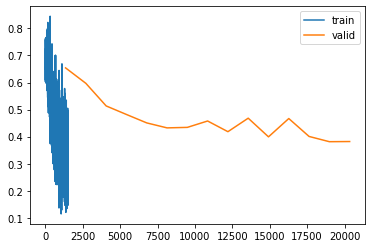

In [27]:
learner.fit(config["epochs"])

### Pretrained with wandb sweep

In [28]:
sweep_config = {'method': 'random',
 'metric': {'goal': 'minimize', 'name': 'loss_eval'},
 'parameters': {'img_size': {'value': 128},
                'epochs': {'value': 5},
                'bs': {'values': [16]},
                'lr': {'values': [0.0001, 0.00005]},
                'embedding_size': {'values': [500, 1000, 2000]},
                'backbone': {'values': ["efficientnet","resnet"]},
                'augmix_tfm': {'values': [True, False]},
                'jitter_tfm': {'value': True},
                'blur_tfm': {'value':  False},
                'randomerase_tfm': {'value': True},
                'reflectpad_tfm': {'value': False},
                'erase_max': {'values': [0.25, 0.3, 0.35]},
                'aff1': {'values': [5,10,20,30]},
                'aff2': {'values': [0.05,0.12,0.20,0.25]},
                'aff3': {'values': [0.05,0.10,0.15,0.20]},
                'aff4': {'values': [10,15,20,25]},
                'wd': {'values': [1e-4, 5e-5, 1e-5, 5e-6]},
                'droupout_p': {'value': 0}
               }}

sweep_id = wandb.sweep(sweep_config, project="signify")

Create sweep with ID: 4khr9r9h
Sweep URL: https://wandb.ai/crashedice/signify/sweeps/4khr9r9h


In [29]:
wandb.agent(sweep_id, train, count=30)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


<IPython.core.display.HTML object>
<IPython.core.display.HTML object>
<IPython.core.display.HTML object>
<IPython.core.display.HTML object>


wandb: Agent Starting Run: 8q6ja3l9 with config:
wandb: 	aff1: 5
wandb: 	aff2: 0.05
wandb: 	aff3: 0.15
wandb: 	aff4: 20
wandb: 	augmix_tfm: False
wandb: 	backbone: resnet
wandb: 	blur_tfm: False
wandb: 	bs: 16
wandb: 	droupout_p: 0
wandb: 	embedding_size: 2000
wandb: 	epochs: 5
wandb: 	erase_max: 0.25
wandb: 	img_size: 128
wandb: 	jitter_tfm: True
wandb: 	lr: 5e-05
wandb: 	randomerase_tfm: True
wandb: 	reflectpad_tfm: False
wandb: 	wd: 0.0001


wandb: WARNING Ignored wandb.init() arg project when running a sweep.


wandb: ERROR Run 8q6ja3l9 errored: TypeError("__init__() got an unexpected keyword argument 'transform'")
wandb: Ctrl + C detected. Stopping sweep.


Error in callback <function _WandbInit._pause_backend at 0x7f93b9272a60> (for post_run_cell):


BrokenPipeError: [Errno 32] Broken pipe

## Inference

In [30]:
model =None

Error in callback <function _WandbInit._resume_backend at 0x7f93bba528b0> (for pre_run_cell):


BrokenPipeError: [Errno 32] Broken pipe

Error in callback <function _WandbInit._pause_backend at 0x7f93b9272a60> (for post_run_cell):


BrokenPipeError: [Errno 32] Broken pipe

In [31]:
weights = torch.load("siamese.pth")

Error in callback <function _WandbInit._resume_backend at 0x7f93bba528b0> (for pre_run_cell):


BrokenPipeError: [Errno 32] Broken pipe

Error in callback <function _WandbInit._pause_backend at 0x7f93b9272a60> (for post_run_cell):


BrokenPipeError: [Errno 32] Broken pipe

In [32]:
device = torch.device('cuda')
backbone = models.efficientnet_v2_s(pretrained=True)
model = SiameseNetwork(backbone, embedding_size=1000).to(device)
model.load_state_dict(weights)

#learner = Learner(model, dlt, dlv, config["lr"], cbs, opt_func=optimizer)
#learner.fit(config["epochs"], train=False, valid=True)

Error in callback <function _WandbInit._resume_backend at 0x7f93bba528b0> (for pre_run_cell):


BrokenPipeError: [Errno 32] Broken pipe

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_S_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


TypeError: Expected state_dict to be dict-like, got <class '__main__.SiameseNetwork'>.

Error in callback <function _WandbInit._pause_backend at 0x7f93b9272a60> (for post_run_cell):


BrokenPipeError: [Errno 32] Broken pipe

In [ ]:


dsv = SiameseDataset(dirnames["valid_clean"], n_samples=100, transform=transform_valid)
dlvdel = DataLoader(dsv, 1, shuffle=True)

for i in dlvdel:
    print(weights(i[0],i[1]))
    show_images(torch.cat((i[0], i[1])))
    break

### Visualize

In [ ]:
#|export
@fc.delegates(plt.Axes.imshow)
def show_image(im, ax=None, figsize=None, title=None, noframe=True, **kwargs):
    "Show a PIL or PyTorch image on `ax`."
    if fc.hasattrs(im, ('cpu','permute','detach')):
        im = im.detach().cpu()
        if len(im.shape)==3 and im.shape[0]<5: im=im.permute(1,2,0)
    elif not isinstance(im,np.ndarray): im=np.array(im)
    if im.shape[-1]==1: im=im[...,0]
    if ax is None: _,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, **kwargs, cmap='gray')
    if title is not None: ax.set_title(title, color="red")
    ax.set_xticks([]) 
    ax.set_yticks([]) 
    if noframe: ax.axis('off')

    return ax

@fc.delegates(plt.subplots, keep=True)
def subplots(
    nrows:int=1, # Number of rows in returned axes grid
    ncols:int=1, # Number of columns in returned axes grid
    figsize:tuple=None, # Width, height in inches of the returned figure
    imsize:int=3, # Size (in inches) of images that will be displayed in the returned figure
    suptitle:str=None, # Title to be set to returned figure
    **kwargs
): # fig and axs
    "A figure and set of subplots to display images of `imsize` inches"
    if figsize is None: figsize=(ncols*imsize, nrows*imsize)
    fig,ax = plt.subplots(nrows, ncols, figsize=figsize, **kwargs)
    if suptitle is not None: fig.suptitle(suptitle)
    if nrows*ncols==1: ax = np.array([ax])

    return fig,ax

@fc.delegates(subplots)
def get_grid(
    n:int, # Number of axes
    nrows:int=None, # Number of rows, defaulting to `int(math.sqrt(n))`
    ncols:int=None, # Number of columns, defaulting to `ceil(n/rows)`
    title:str=None, # If passed, title set to the figure
    weight:str='bold', # Title font weight
    size:int=14, # Title font size
    **kwargs,
): # fig and axs
    "Return a grid of `n` axes, `rows` by `cols`"
    if nrows: ncols = ncols or int(np.floor(n/nrows))
    elif ncols: nrows = nrows or int(np.ceil(n/ncols))
    else:
        nrows = int(math.sqrt(n))
        ncols = int(np.floor(n/nrows))
    fig,axs = subplots(nrows, ncols, **kwargs)
    for i in range(n, nrows*ncols): axs.flat[i].set_axis_off()
    if title is not None: fig.suptitle(title, weight=weight, size=size)
    return fig,axs

@fc.delegates(subplots)
def show_images(ims:list, # Images to show
                nrows:int|None=None, # Number of rows in grid
                ncols:int|None=None, # Number of columns in grid (auto-calculated if None)
                titles:list|None=None, # Optional list of titles for each image
                **kwargs):
    "Show all images `ims` as subplots with `rows` using `titles`"
    axs = get_grid(len(ims), nrows, ncols, **kwargs)[1].flat
    for im,t,ax in zip_longest(ims, titles or [], axs): show_image(im, ax=ax, title=t)

def reshape_alternating(tens1, tens2):
    new =  torch.stack((tens1, tens2), dim=0)
    return torch.transpose(new,0,1).flatten(start_dim=0, end_dim=1)

In [ ]:
class SquarePad:
	def __call__(self, image):
		w, h = image.size
		max_wh = np.max([w, h])
		hp = int((max_wh - w) / 2)
		vp = int((max_wh - h) / 2)
		padding = (hp, vp, hp, vp)
		return F.pad(image, padding, 0, 'constant')

In [ ]:
basePath = Path("/storage/projects/signature/signify")
dataPath = basePath / "sigData"/"train"

import torchvision.transforms.functional as F

class SquarePad:
    def __call__(self, image):
        image = image.squeeze()
        s = image.size()
        max_wh = np.min([s[-1], s[-2] * 2.9])
        hp = np.max(int((max_wh - s[-1]) / 2), 0)
        vp = np.max(int((max_wh - s[-2]) / 2), 0)
        padding = (0, vp, 0, vp)
        new_img = F.pad(image, padding, padding_mode='reflect')
        return new_img.unsqueeze(0)
transform_valid = transforms.Compose([
    transforms.ToTensor(),
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((124, 124)),
    transforms.Normalize((0.8981),(0.1322))
])
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((124, 124)),
    transforms.RandomAffine(0, (0.2, 0.2), (0.5, 0.8), [-15,15,-15,15], fill=1.),
    transforms.RandomErasing(scale=(0.02,0.25)),
    transforms.RandomApply(torch.nn.ModuleList([transforms.ColorJitter(brightness=(0.7,1.3),contrast=(0.7,1.3),saturation=(0.7,1.3), hue=(-0.1, 0.1))]), p=0.7),
    transforms.Normalize((0.8981),(0.1322))
])


train_data = SiameseDataset(dirnames["valid"], n_samples=500, transform=transform_train)
#val_data = SiameseDataset(path_valid, transform=transform)
it = iter(DataLoader(train_data, 10, shuffle=True))


In [ ]:
train_data = SiameseDataset(dirnames["valid"], n_samples=500, transform=None)

transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Grayscale(num_output_channels=1),
    transforms.RandomErasing(scale=(0.02,0.25)),
    transforms.RandomAffine(20, (0.2, 0.2), (1., 1.), [-15,15,-15,15], fill=1.),
    transforms.Resize((124, 124)),
    transforms.RandomApply(torch.nn.ModuleList([transforms.ColorJitter(brightness=(0.7,1.3),contrast=(0.7,1.3),saturation=(0.7,1.3), hue=(-0.1, 0.1))]), p=0.7),

    ])

seed = torch.seed()

x1_first = transform_train(train_data[0][0])
torch.manual_seed(seed)

x1_sec = transform_train(train_data[0][1])

show_images(x1_first)
show_images(x1_sec)


In [ ]:
x1, x2, label = next(it)

shear1, shear2 = random.sample(range(-20,20),10), random.sample(range(-20,20),10)

labels = torch.repeat_interleave(label, 2)
images = reshape_alternating(x1, x2)

show_images(images,ncols=2,titles=labels.tolist())

In [ ]:
train_data = SiameseDataset(dirnames["valid"], n_samples=500, transform=transform_train)
#val_data = SiameseDataset(path_valid, transform=transform)
it = iter(DataLoader(train_data, 10, shuffle=True))

x1, x2, label = next(it)

labels = torch.repeat_interleave(label, 2)
images = reshape_alternating(x1, x2)

show_images(images,ncols=2,titles=labels.tolist())

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()